In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import tensorflow
import pandas as pd

from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from custom_models import AdaptativeDataWeightModel

2025-09-15 01:21:58.083563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:

data_I = pd.read_csv("../data/sir-es-7d.csv")["I"].to_numpy()
data_I[:10]

array([5.28571429, 5.28571429, 5.        , 4.42857143, 4.        ,
       3.85714286, 4.28571429, 4.57142857, 4.71428571, 5.14285714])

In [3]:
t0, tf = 0, 365
gamma = 0.2
N = 3833486 # population size
data_I_norm = data_I / N
S0, I0, R0 = 1.0, data_I_norm[0], 0.0

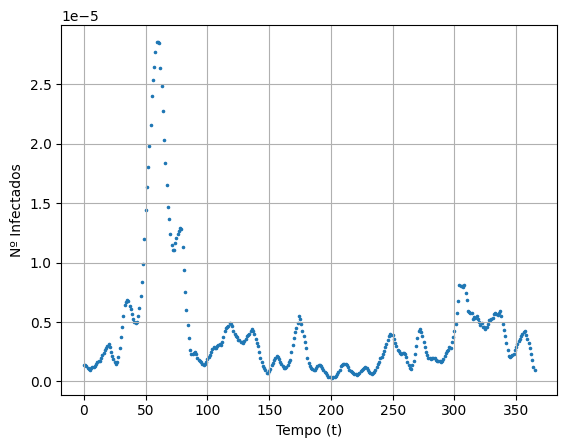

In [4]:
train_t = np.linspace(t0, tf, 366)
# plt.scatter(train_t, data_I, s=2.5)
plt.scatter(train_t, data_I_norm, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("Nº Infectados")
plt.grid()
plt.show()

In [5]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_I_bc = PointSetBC(data_t, data_I_norm, component=1)

ics = [ic_S, ic_I]
data_conds = [
    data_I_bc
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=1024,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 5
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
activation = "tanh"
# activation = "ReLU"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic1_w = 1
ic2_w = 1
data_w = 1

# loss_weights = [eq_w] * 2 + [ic1_w, ic2_w]
loss_weights = [eq_w] * 2 + [ic1_w, ic2_w]  + [data_w] * len(data_conds) + [1]
# loss_weights = [eq_w] * 2 + [ic_w] * len(ics) + [data_w] * len(data_conds)

net = FNN(
    topology, 
    activation, 
    initializer,
    regularization=["L2", 1],
    dropout_rate=0,
)

# net = PFNN(
#     topology, 
#     activation, 
#     initializer
# )

# def non_zero_hard_constraint(x, y):
#     return tensorflow.nn.relu(y)

# net.apply_output_transform(non_zero_hard_constraint)

model = AdaptativeDataWeightModel(data, net, n_physics=4, n_data=1)
# model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.007125 s



2025-09-15 01:22:02.308308: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1757910122.309083  136888 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
early_stopping = EarlyStopping(min_delta=1e-7, patience=15000)

adam_iterations = 20000

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=100,
    callbacks=[
        early_stopping
    ]
)

Training model...



2025-09-15 01:22:04.107507: I external/local_xla/xla/service/service.cc:163] XLA service 0x55d410970e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-15 01:22:04.107525: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-09-15 01:22:04.120741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-15 01:22:04.198735: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1757910124.602210  136888 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                      Test loss                                                       Test metric
0         [4.41e-03, 1.68e-03, 1.00e+00, 1.90e-12, 1.43e-02, 2.11e+02]    [4.25e-03, 1.67e-03, 1.00e+00, 1.90e-12, 1.43e-02, 2.11e+02]    []  
100       [2.99e-09, 9.24e-09, 7.87e-02, 7.71e-06, 4.03e-07, 1.68e+01]    [2.16e-09, 9.03e-09, 7.87e-02, 7.71e-06, 4.03e-07, 1.68e+01]    []  
200       [1.99e-13, 1.18e-08, 3.48e-02, 2.96e-07, 2.94e-07, 1.07e+00]    [2.00e-13, 1.18e-08, 3.48e-02, 2.96e-07, 2.94e-07, 1.07e+00]    []  
300       [2.96e-13, 3.50e-11, 1.48e-02, 6.50e-10, 5.35e-10, 1.03e-01]    [2.96e-13, 3.50e-11, 1.48e-02, 6.50e-10, 5.35e-10, 1.03e-01]    []  
400       [6.19e-13, 5.71e-11, 7.40e-03, 1.24e-09, 1.48e-09, 3.68e-02]    [6.19e-13, 5.71e-11, 7.40e-03, 1.24e-09, 1.48e-09, 3.68e-02]    []  
500       [9.08e-15, 8.89e-13, 4.11e-03, 3.16e-11, 9.77e-11, 2.14e-02]    [9.08e-15, 8.89e-13, 4.11e-03, 3.16e-11, 9.77e-11, 2.14e-02] 

In [7]:
# model.save("../models/sir-nonoise")
# dde.saveplot(
#     losshistory, 
#     train_state, 
#     issave=True, 
#     isplot=False,
#     output_dir="../losses", 
#     loss_fname=f"loss-sir-nonoise",
#     train_fname=f"train-sir-nonoise",
#     test_fname=f"test-sir-nonoise")

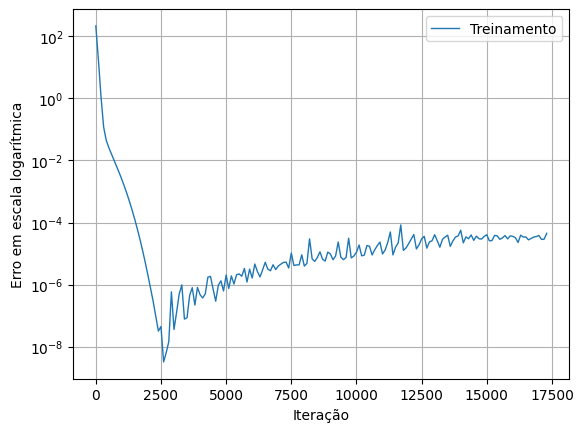

In [8]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
# plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

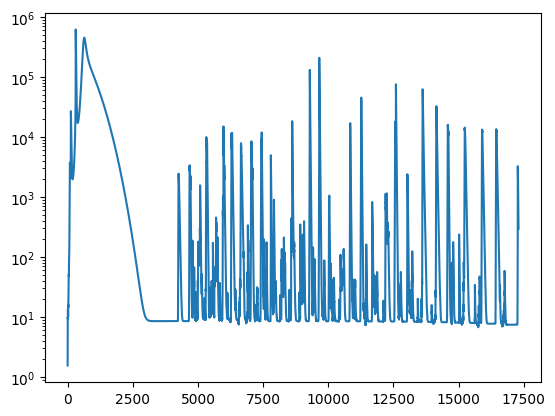

In [9]:
plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
plt.show()

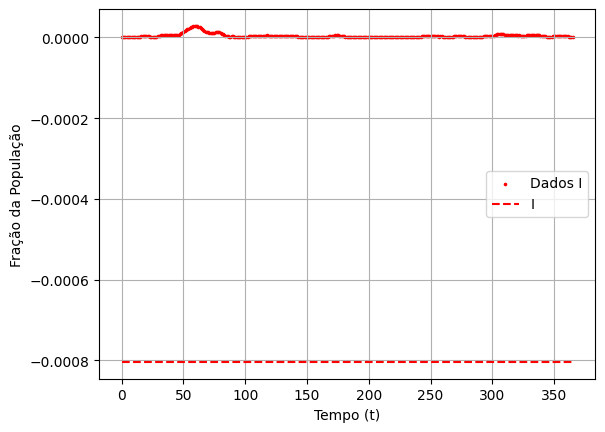

In [10]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred = y_pred[:, 0]
I_pred = y_pred[:, 1]

plt.scatter(train_t, data_I_norm, label="Dados I", color="red", s=2.5)
# plt.plot(test_t, S_pred, label="S", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I", linestyle="--", color="red")
# plt.semilogy(test_t, S_pred, label="S", linestyle="--", color="blue")
# plt.semilogy(test_t, I_pred, label="I", linestyle="--", color="red")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()

plt.show()

In [11]:
y_pred[:, 0]

array([0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909, 0.9984909,
       0.9984909, 0.9984909, 0.9984909, 0.9984909, 

[]

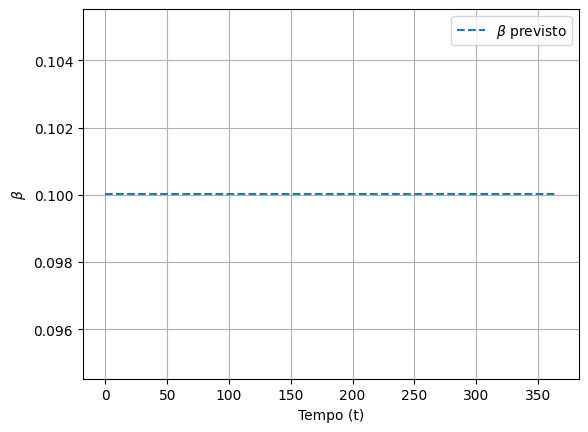

In [12]:
beta_pred = y_pred[:, 2]
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.plot()